In [1]:
import tensorflow as tf
import time
import tensorflow_hub as hub
import cv2
from PIL import Image
import uuid

from EfficientDet import *
import os
from glob import glob

# test_input에 대해서 object detection 수행

## pretrained model 가져오기

In [2]:
model = get_detector("https://tfhub.dev/tensorflow/efficientdet/d4/1")

In [5]:
dataset_path = "./original_test/"
output_path = "./detected_data/detected_from_test/"
dataset_list = os.listdir("./original_test")

In [6]:
detected_objectList = object_detection(model, dataset_list,dataset_path, output_path)

Detection 수행시간: 0.18 초
Detection 수행시간: 0.18 초
Detection 수행시간: 0.19 초
Detection 수행시간: 0.19 초
Detection 수행시간: 0.2 초
Detection 수행시간: 0.2 초


# detected object를 선택


In [25]:
selectedObject = detected_objectList[0]

selectedObject_path = selectedObject["objectImagePath"]

In [26]:
selectedObject_pil = Image.open(selectedObject_path)


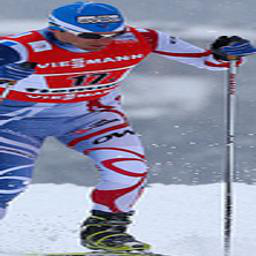

In [27]:
selectedObject_pil

1. readTest 다시 짜기 > selectedObject 하나만 읽어야함
2. read_imgs_test를 다시짜야함
3. apply_transformer도 selectedObject 하나만 변환하도록

In [28]:
from ImageRetrievalClass import ImageRetrievalClass
retrieval = ImageRetrievalClass("IncepResNet", True, False)
retrieval.readTestSet(selectedObject_pil)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


Reading train images
test image shape = (256, 256, 3)


In [29]:
retrieval.buildModel()

Loading IncepResNet pre-trained model...
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 127, 127, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 127, 127, 32) 0           batch_normalization_203[0][0]    
_______________________________________

In [30]:
X_test = retrieval.testTransform()


Applying image transformer to test images...
 -> X_test.shape = (1, 256, 256, 3)


In [31]:
E_test = retrieval.predictTest(X_test)
E_test_flatten = E_test.reshape((-1, np.prod(retrieval.output_shape_model)))

Inferencing embeddings using pre-trained model...
 -> E_test.shape = (1, 6, 6, 1536)


# 동일 태그를 가진 객체들을 검색대상 pool에서 가져오기
- 추후 mongoDB 쿼리부분으로 바뀌어야 함

In [32]:
jsonFiles_path = glob("./jsonFiles/*.json")

In [33]:
import json
queryed_json_pathList = list()
queryed_jsonList = list()
for path in jsonFiles_path:
    with open(path, "rb") as f:
        jsonFile = json.load(f)
    
    if jsonFile["tag"] == "person":
        queryed_json_pathList.append(path)
        queryed_jsonList.append(jsonFile)

In [34]:
queryed_jsonList[0]

{'objectID': '76ed9259-f1dc-4472-9eab-05d0b4bcf11c',
 'location': {'xmin': 27, 'ymin': 295, 'xmax': 448, 'ymax': 419},
 'tag': 'person',
 'objectImagePath': './detected_data/detected_from_train/person2632_path_(.-original_train-person000206.png).jpg',
 'npyPath': './npyFiles/person2632_path_(.-original_train-person000206.png).npy',
 'IMG_URL': 'person000206.png'}

# 태그로 쿼리한 json 파일의 npy(E_train)과 E_test를 비교

## json에서 npy가져와서 E_train 만들기

In [35]:
E_train = list()
for json in queryed_jsonList:
    npy = np.load(json["npyPath"])
    E_train.append(npy)


In [36]:
E_train = np.array(E_train)


In [37]:
E_train_flatten = E_train.reshape((-1, np.prod(retrieval.output_shape_model)))
E_test_flatten.shape

(1, 55296)

In [38]:
# E_train_flatten =np.load("E_train_flatten.npy")

In [39]:
E_train_flatten.shape

(3031, 55296)

In [40]:
calculator = retrieval.similarityCalculator(E_train_flatten)

Fitting k-nearest-neighbour model on training images...


## 쿼리 결과의 pool 만들기

In [41]:
retrieval_imagePool = [Image.open(json["objectImagePath"]) for json in queryed_jsonList]



## Retrieval

In [42]:
retrieval.retrieval(E_test_flatten=E_test_flatten, calculator=calculator, retrieval_imagePool=retrieval_imagePool )

Performing image retrieval on test images...


E_test_flatten.shape

In [ ]:
# 원본 이미지 

In [ ]:
from src.CV_IO_utils import read_imgs_dir, read_imgs_list, read_one_image
from src.CV_plot_utils import plot_query_retrieval, plot_tsne, plot_reconstructions

# E_test_flatten = E_test.reshape((-1, np.prod(self.output_shape_model)))
imgs_retrieval_pil = list()
# find k nearest train neighbours
_, indices = calculator.kneighbors(E_test_flatten)

imgs_train = read_imgs_list(retrieval_imagePool)

img_query = retrieval.imgs_test[0]  # query image
imgs_retrieval = [imgs_train[idx] for idx in indices.flatten()]  # retrieval images

imgs_retrieval_idx = [idx for idx in indices.flatten()]

len(imgs_retrieval)
# outFile = os.path.join(retrieval.outDir, "{}_retrieval_{}.png".format(retrieval.modelName, i))
# plot_query_retrieval(img_query, imgs_retrieval, outFile)

In [ ]:
indices

In [ ]:
imgs_retrieval_idx

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,10))

for idx,img in enumerate(imgs_retrieval):
    ax = fig.add_subplot(1, len(imgs_retrieval), idx+1)
    ax.set_title("#1")
    ax.imshow(img)
plt.show()
